In [1]:
# imports

import numpy as np
import pandas as pd 
from pathlib import Path

from collections import Counter

from sklearn.model_selection import train_test_split

from PIL import Image


import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.transforms import (Compose,
                                    RandomResizedCrop, 
                                    Resize,
                                    CenterCrop,
                                    RandomHorizontalFlip, 
                                    RandomVerticalFlip, 
                                    RandomPerspective, 
                                    RandomRotation,
                                    ColorJitter,
                                    Normalize,
                                    ToTensor
                                   )

import torchmetrics
from tqdm.notebook import tqdm
from torchsummary import summary
from sklearn.metrics import confusion_matrix

import gc

# **Preparing Data**

In [ ]:
#準備讀取資料
paths = []
labels = []
import os
        
ds_path = 'animals/'
for category in ['cats','dogs','panda']:
    for p in os.listdir(os.path.join(ds_path, category)):
        f = Path(os.path.join(ds_path,category, p))
        paths.append(f)
        labels.append(f.parent.stem)

In [3]:
Counter(labels)

Counter({'cats': 1000, 'dogs': 1000, 'panda': 1000})

In [4]:
# variation in image sizes

sizes = []
for path in paths:
    im = Image.open(path)
    sizes.append(im.size)
    im.close()
    
print(max(sizes), min(sizes))
del sizes

(1600, 1200) (55, 75)


In [ ]:
#分割訓練與驗證集
x_train, x_test, y_train, y_test = train_test_split(paths, labels, test_size=0.2, random_state=0)

## Augmentations

In [6]:
#基礎影像處理
basic_augmentations = Compose([
    Resize(224),
    CenterCrop(224),
    ToTensor()
])

basic_augmentations2 = Compose([
    RandomResizedCrop(224),
    ToTensor()
])

In [7]:
#訓練集與驗證集影像處理
train_augmentations = Compose([
    RandomResizedCrop(224),
    RandomHorizontalFlip(1),
    RandomVerticalFlip(0.1),
    RandomPerspective(distortion_scale=0.2, p=0.2),
    RandomRotation(15),
    ToTensor(),
    Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
val_augmentations = Compose([
    Resize(384),
    CenterCrop(224),
    ToTensor(),
    Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [8]:
#Dataloader
class AnimalDataset:
    
    def __init__(self, paths, labels, augmentations):
        self.paths = paths
        self.labels = labels
        self.classes = {
            'panda': 0,
            'dog': 1,
            'cat': 2
        }
        self.augmentations = augmentations
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        
        sample = Image.open(self.paths[idx]).convert(mode="RGB")
        sample = self.augmentations(sample)
        
        label = self.labels[idx]
        if label == 'panda':
            label = 0
        elif label == 'dogs':
            label = 1
        elif label == 'cats':
            label = 2
        
        return (sample, torch.tensor(label, dtype=torch.long))

In [9]:
train_ds = AnimalDataset(x_train, y_train, train_augmentations)
val_ds = AnimalDataset(x_test, y_test, val_augmentations)

# **Visualization**

In [10]:
plot_ds = AnimalDataset(x_train[:16], y_train[:16], basic_augmentations)

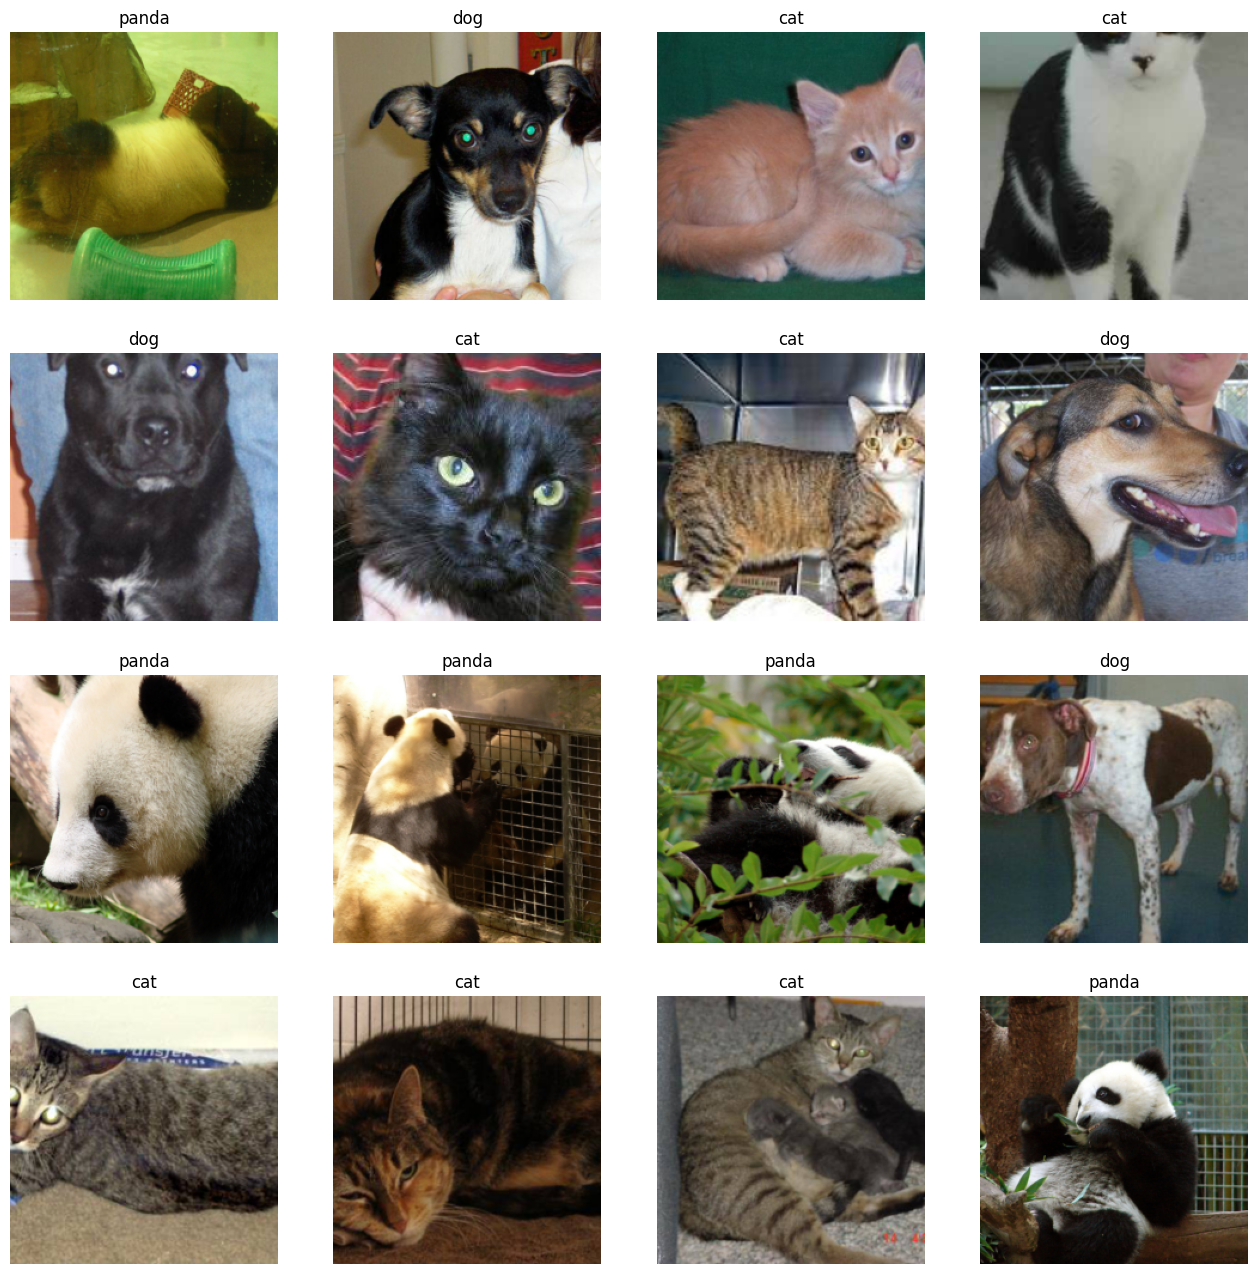

In [11]:
to_plot = []
classes = { 0: 'panda',
            1: 'dog',
            2: 'cat'
          }
for x,y in plot_ds:
    to_plot.append((x,y))
    
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(16,16))
for i in range(1,17):
    img = to_plot[i-1][0].permute(1,2,0)
    label = classes[(to_plot[i-1][1]).item()]
    figure.add_subplot(4,4,i)
    plt.title(label)
    plt.axis('off')
    plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

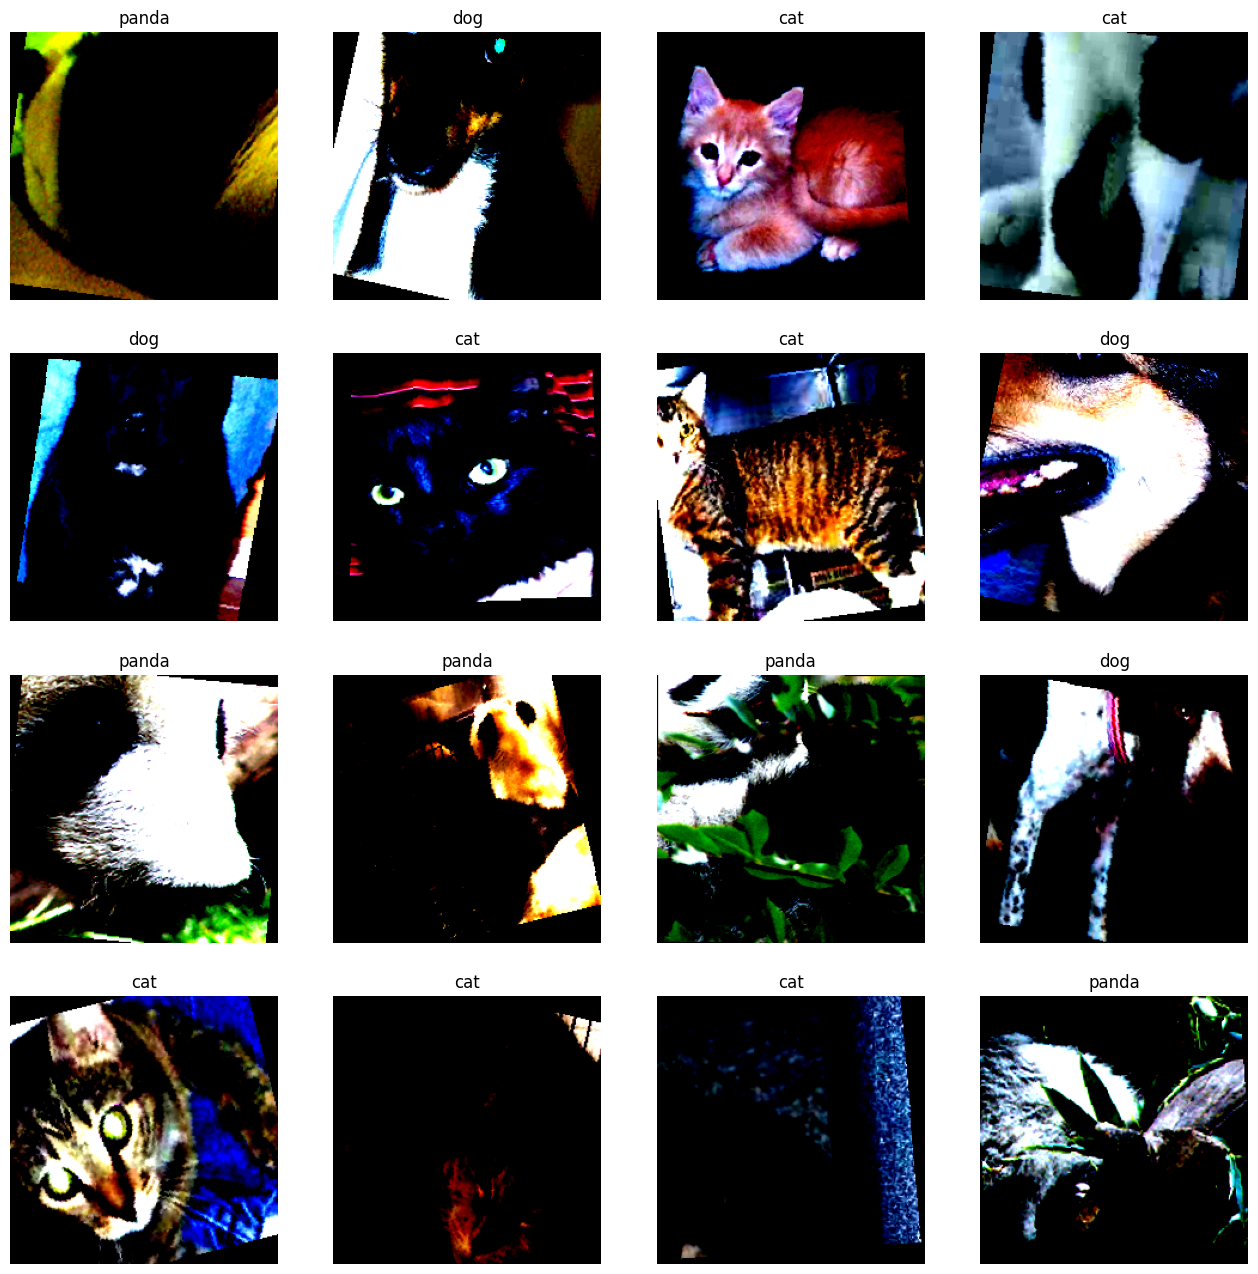

In [12]:
plot_ds_augmented = [train_ds[i] for i in range(16)]

figure = plt.figure(figsize=(16,16))
for i in range(1,17):
    img = plot_ds_augmented[i-1][0].permute(1,2,0)
    label = classes[(to_plot[i-1][1]).item()]
    figure.add_subplot(4,4,i)
    plt.title(label)
    plt.axis('off')
    plt.imshow(img)

## Dataloaders

In [13]:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=64, num_workers=0, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=64, num_workers=0, shuffle=True)

In [14]:
len(train_loader), len(val_loader)

(38, 10)

# **Model** 

In [15]:
#baseline模型backbone有4層，head由Flatten、AdaptiveAvgPool1d、Linear組成
class CNNModel(nn.Module):
    
    def __init__(self, in_features=3, num_classes=3):
        self.in_features = in_features
        self.num_classes = num_classes
        
        super(CNNModel, self).__init__()
        
        self.backbone = nn.Sequential(
            nn.Conv2d(self.in_features,32,3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32,64,3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64,128,3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(128,256,3),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),
            
            nn.Dropout2d(0.5)
        )
        
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.AdaptiveAvgPool1d(256),
            nn.Linear(256,self.num_classes)
        )

    def forward(self,x):
        x = self.backbone(x)
        x = self.head(x)
        return x

In [16]:
print(CNNModel())

CNNModel(
  (backbone): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout2d(p=0.5, inplace=False)
  )
  (head): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): AdaptiveAvgPool1d(output

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# **Training**

在初始化方法中，訓練器接受了模型、數據加載器和配置參數作為輸入。它會將模型、數據加載器和配置參數保存下來，並初始化了損失函數、優化器和學習率調整器（如果啟用了調度器），以及一系列的指標評估器用於評估模型的性能。

訓練過程分為兩個主要步驟：訓練一個 epoch 和驗證一個 epoch。在訓練一個 epoch 的過程中，模型被設置為訓練模式，遍歷訓練數據集，計算並更新損失，同時記錄訓練指標的變化。在驗證一個 epoch 的過程中，模型被設置為評估模式，遍歷驗證數據集，計算並記錄驗證損失和指標。

在每個 epoch 結束後，會根據記錄的損失和指標打印出訓練和驗證的表現。同時，如果驗證準確率優於之前記錄的最佳準確率，則更新最佳驗證準確率和對應的 epoch。

訓練過程中會在每個 epoch 的開始和結束時清理內存，以避免內存泄漏和減少內存使用。

In [18]:
class Trainer:
    
    def __init__(self, model, loaders, config):
        self.model = model
        self.train_loader, self.val_loader = loaders
        self.config = config
        
        self.loss_fn = nn.CrossEntropyLoss()
        self.optim1 = torch.optim.SGD(self.model.parameters(), 
                                     lr=self.config['lr'], 
                                     momentum=self.config['sgd_momentum']
                                    )
        self.optim2 = torch.optim.Adam(self.model.parameters(),
                                       lr = self.config['lr']
                                      )
        self.optim3 = torch.optim.AdamW(self.model.parameters(),
                                        lr=self.config['lr'],
#                                         default weight decay: 1e-3
                                       )
        
        
        self.optim = self.optim3
        
        if self.config['scheduler']:
            self.scheduler = torch.optim.lr_scheduler.StepLR(optimizer=self.optim,
                                                             step_size=self.config['sch_step_size'], 
                                                             gamma=self.config['sch_gamma']
                                                            )
            
            
        metrics = torchmetrics.MetricCollection([
            torchmetrics.Accuracy(average='macro', num_classes=3, task='multiclass'),
            torchmetrics.Precision(average='macro', num_classes=3, task='multiclass'),
            torchmetrics.Recall(average='macro', num_classes=3, task='multiclass'),
            torchmetrics.F1Score(average='macro', num_classes=3, task='multiclass')
        ]).to(self.config['device'])
        self.train_metrics = metrics.clone(prefix='train_')
        self.val_metrics = metrics.clone(prefix='val_')

        
        self.train_logs = []
        self.val_logs = []
        
    def logger(self, epoch, metrics, loss, mode):
        
        metrics = {metric:metrics[metric].cpu().item() for metric in metrics}
    
        log = {
            f'epoch_{epoch-1}': {
                'loss': loss,
                'metrics': metrics
            }
        }
        if mode == 'train':
            self.train_logs.append(log)
        else:
            self.val_logs.append(log)
            
    def print_per_epoch(self, epoch):
        print(f"\n\n{'-'*30}EPOCH {epoch}/{self.config['epochs']}{'-'*30}")
        epoch = epoch-1 
        train_loss = self.train_logs[epoch][f'epoch_{epoch}']['loss']
        train_acc = self.train_logs[epoch][f'epoch_{epoch}']['metrics']['train_MulticlassAccuracy']
        val_loss = self.val_logs[epoch][f'epoch_{epoch}']['loss']
        val_acc = self.val_logs[epoch][f'epoch_{epoch}']['metrics']['val_MulticlassAccuracy']
        print(f"Train -> LOSS: {train_loss} | ACC: {train_acc}")
        print(f"Validation -> LOSS: {val_loss} | ACC: {val_acc}\n\n\n")
        
    def train_one_epoch(self, epoch):
        
        running_loss = 0
        progress = tqdm(self.train_loader, total=len(self.train_loader))
        for x,y in progress:
            
            self.optim.zero_grad()
        
            x = x.to(self.config['device'])
            y = y.to(self.config['device'])
            
            preds = self.model(x)
            
            loss = self.loss_fn(preds, y)
            running_loss += loss.item()
            loss.backward()
            self.optim.step()
            
            self.train_metrics(torch.argmax(preds, dim=1), y)
            progress.set_description(f"Train Loss Step: {loss.item():.3f}")
            
            del x,y,preds,loss
            
        if self.config['scheduler']:
            self.scheduler.step()
            
        metrics = self.train_metrics.compute()
        train_loss = running_loss / len(self.train_loader)
        
        self.logger(epoch,metrics,train_loss,'train')

        del metrics
        
    @torch.no_grad()
    def valid_one_epoch(self, epoch):
        
        running_loss = 0
        progress = tqdm(self.val_loader, total=len(self.val_loader))
        for x,y in progress:
            
            x = x.to(self.config['device'])
            y = y.to(self.config['device'])
            
            preds = self.model(x)
            loss = self.loss_fn(preds, y)
            running_loss += loss.item()
            
            self.val_metrics(torch.argmax(preds, dim=1), y)
            progress.set_description(f"Validation Loss Step: {loss.item():.3f}")
            del x,y,preds,loss
            
        metrics = self.val_metrics.compute()
        val_loss = running_loss / len(self.val_loader)
        self.logger(epoch,metrics,val_loss,'val')
        
        del metrics
        
    def clear(self):
        gc.collect()
        torch.cuda.empty_cache()
            
        
    def fit(self):
        
        fit_progress = tqdm(
            range(1, self.config['epochs']+1),
            leave = True,
            desc="Training..."
        )
        for epoch in fit_progress:
            
            self.model.train()
            fit_progress.set_description(f"EPOCH {epoch} / {self.config['epochs']} | training...")
            self.train_one_epoch(epoch)
            self.clear()
            
            self.model.eval()
            fit_progress.set_description(f"EPOCH {epoch} / {self.config['epochs']} | validating...")
            self.valid_one_epoch(epoch)
            self.clear()
            
            # reset metrics
            self.train_metrics.reset()
            self.val_metrics.reset()
            
            # print metrics
            self.print_per_epoch(epoch)

In [19]:
gc.collect()
torch.cuda.empty_cache()

# **Trainer with scheduler**

In [20]:
config = {
    'lr': 1e-3,
    'epochs': 20,
    'sgd_momentum': 0.8,
    'scheduler': True,
    'sch_step_size': 2,
    'sch_gamma': 0.2,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}
print("training on:",config['device'])
model = CNNModel().to(device=config['device'])
trainer = Trainer(model, (train_loader, val_loader), config)

training on: cuda


Training...:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]



------------------------------EPOCH 1/20------------------------------
Train -> LOSS: 0.8846433413656134 | ACC: 0.5691867470741272
Validation -> LOSS: 0.8314274549484253 | ACC: 0.5982855558395386





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]



------------------------------EPOCH 2/20------------------------------
Train -> LOSS: 0.8078209412725348 | ACC: 0.5950568318367004
Validation -> LOSS: 0.950816535949707 | ACC: 0.5134757161140442





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]



------------------------------EPOCH 3/20------------------------------
Train -> LOSS: 0.7722714527657157 | ACC: 0.6193146705627441
Validation -> LOSS: 0.784723699092865 | ACC: 0.6191555261611938





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]



------------------------------EPOCH 4/20------------------------------
Train -> LOSS: 0.7491280624741002 | ACC: 0.6393541097640991
Validation -> LOSS: 0.7265001893043518 | ACC: 0.6701245307922363





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]



------------------------------EPOCH 5/20------------------------------
Train -> LOSS: 0.7402077066270929 | ACC: 0.6503888368606567
Validation -> LOSS: 0.7098328828811645 | ACC: 0.6772123575210571





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]



------------------------------EPOCH 6/20------------------------------
Train -> LOSS: 0.7063702266467246 | ACC: 0.6560841202735901
Validation -> LOSS: 0.6951194167137146 | ACC: 0.6983944773674011





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]



------------------------------EPOCH 7/20------------------------------
Train -> LOSS: 0.7127918710834101 | ACC: 0.6569743156433105
Validation -> LOSS: 0.6948790848255157 | ACC: 0.694189190864563





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]



------------------------------EPOCH 8/20------------------------------
Train -> LOSS: 0.7288881744209089 | ACC: 0.6458892226219177
Validation -> LOSS: 0.6848389983177186 | ACC: 0.697545051574707





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]



------------------------------EPOCH 9/20------------------------------
Train -> LOSS: 0.7262378350684517 | ACC: 0.6561010479927063
Validation -> LOSS: 0.7041637897491455 | ACC: 0.6982972025871277





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]



------------------------------EPOCH 10/20------------------------------
Train -> LOSS: 0.7148867390657726 | ACC: 0.6512835025787354
Validation -> LOSS: 0.6801132261753082 | ACC: 0.6967374682426453





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]



------------------------------EPOCH 11/20------------------------------
Train -> LOSS: 0.7135842693479437 | ACC: 0.6487159729003906
Validation -> LOSS: 0.6967493832111359 | ACC: 0.6897606253623962





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]



------------------------------EPOCH 12/20------------------------------
Train -> LOSS: 0.7205176667163247 | ACC: 0.651974618434906
Validation -> LOSS: 0.6867015480995178 | ACC: 0.6981998682022095





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]



------------------------------EPOCH 13/20------------------------------
Train -> LOSS: 0.7058967273486288 | ACC: 0.6535012125968933
Validation -> LOSS: 0.6769033074378967 | ACC: 0.6948435306549072





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]



------------------------------EPOCH 14/20------------------------------
Train -> LOSS: 0.7253014131596214 | ACC: 0.6546560525894165
Validation -> LOSS: 0.6859418630599976 | ACC: 0.6987428069114685





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]



------------------------------EPOCH 15/20------------------------------
Train -> LOSS: 0.7092078265390898 | ACC: 0.6653176546096802
Validation -> LOSS: 0.6881262242794037 | ACC: 0.6982972025871277





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]



------------------------------EPOCH 16/20------------------------------
Train -> LOSS: 0.7187706232070923 | ACC: 0.653897762298584
Validation -> LOSS: 0.690797108411789 | ACC: 0.7026839852333069





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]



------------------------------EPOCH 17/20------------------------------
Train -> LOSS: 0.7109168109140898 | ACC: 0.6512949466705322
Validation -> LOSS: 0.6781451284885407 | ACC: 0.6945093274116516





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]



------------------------------EPOCH 18/20------------------------------
Train -> LOSS: 0.7325021671621423 | ACC: 0.6430739164352417
Validation -> LOSS: 0.6857763409614563 | ACC: 0.6943005919456482





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]



------------------------------EPOCH 19/20------------------------------
Train -> LOSS: 0.7124046526457134 | ACC: 0.6621371507644653
Validation -> LOSS: 0.6846193134784698 | ACC: 0.7016671299934387





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]



------------------------------EPOCH 20/20------------------------------
Train -> LOSS: 0.7164279740107687 | ACC: 0.6591207981109619
Validation -> LOSS: 0.6805592596530914 | ACC: 0.694732129573822





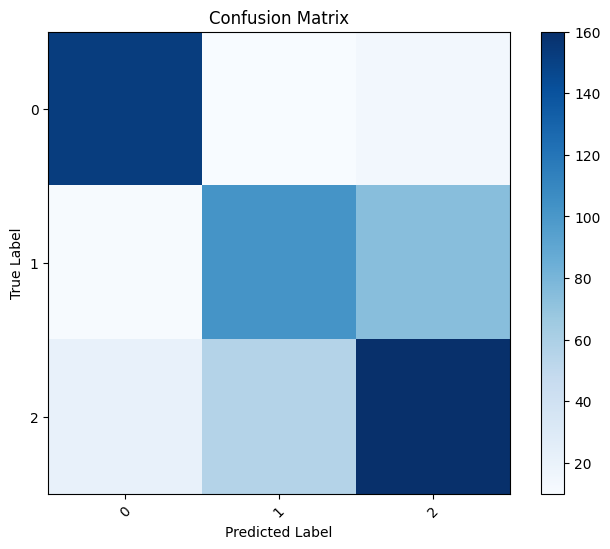

In [21]:
trainer.fit()

In [22]:
# trainer.train_logs

In [23]:
# trainer.val_logs

# **PLOTS**

In [ ]:
def get_metric(metrics, mode, metric):
    values = []
    for i in range(config['epochs']):
        base = metrics[i][f'epoch_{i}']
        if metric == 'loss':
            value = base['loss']
        else:
            value = base['metrics'][f'{mode}_Multiclass{metric}']
        values.append(value)
        
    return values

## Loss Plot

Text(0.5, 1.0, 'Loss')

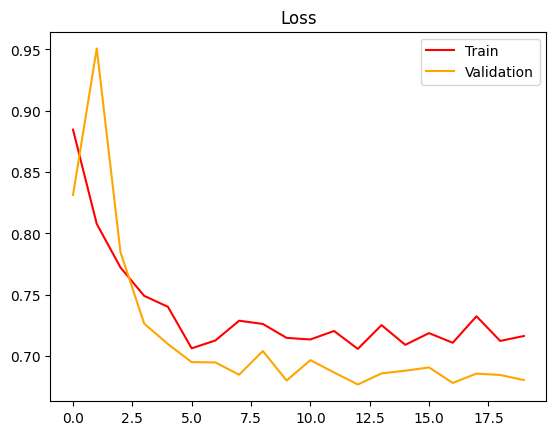

In [25]:
plt.plot(get_metric(trainer.train_logs,'train','loss'), color='red')
plt.plot(get_metric(trainer.val_logs,'val','loss'), color='orange')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.title('Loss')

## Accuracy Plot

Text(0.5, 1.0, 'Accuracy')

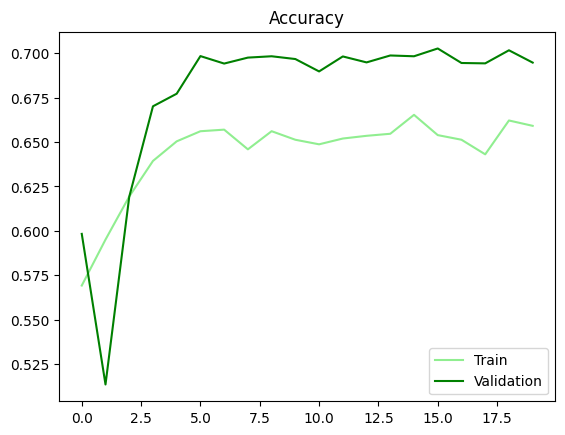

In [26]:
plt.plot(get_metric(trainer.train_logs,'train','Accuracy'), color='lightgreen')
plt.plot(get_metric(trainer.val_logs,'val','Accuracy'), color='green')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.title('Accuracy')

## Precision Plot

Text(0.5, 1.0, 'Precision')

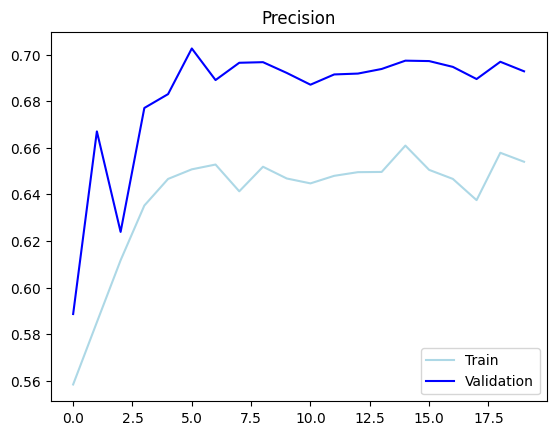

In [27]:
plt.plot(get_metric(trainer.train_logs,'train','Precision'), color='lightblue')
plt.plot(get_metric(trainer.val_logs,'val','Precision'), color='blue')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.title('Precision')

## Recall Plot

Text(0.5, 1.0, 'Recall')

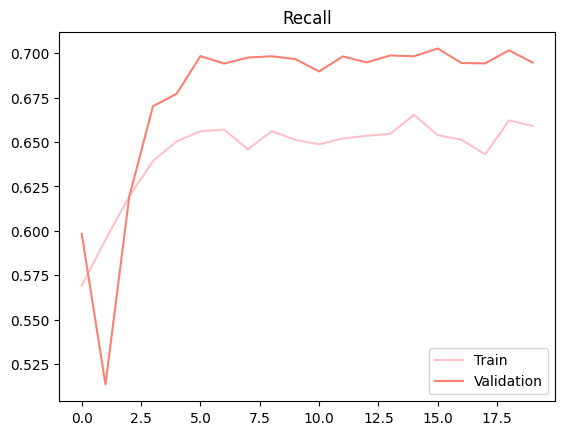

In [28]:
plt.plot(get_metric(trainer.train_logs,'train','Recall'), color='pink')
plt.plot(get_metric(trainer.val_logs,'val','Recall'), color='salmon')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.title('Recall')

## F1Score Plot

Text(0.5, 1.0, 'F1Score')

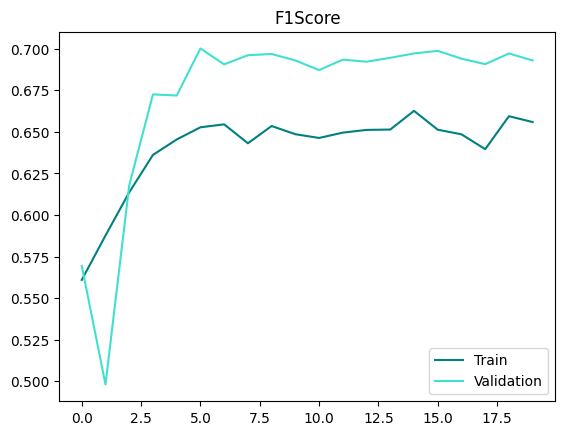

In [29]:
plt.plot(get_metric(trainer.train_logs,'train','F1Score'), color='teal')
plt.plot(get_metric(trainer.val_logs,'val','F1Score'), color='turquoise')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.title('F1Score')

## 模型修改

In [40]:
#優化模型CNNModel backbone有4層、DeepCNNModel改為5層並且輸出512 channel，head一樣由Flatten、AdaptiveAvgPool1d、Linear組成
import torch.nn as nn
import torch.nn.functional as F

class DeepCNNModel(nn.Module):
    
    def __init__(self, in_features=3, num_classes=3):
        self.in_features = in_features
        self.num_classes = num_classes
        
        super(DeepCNNModel, self).__init__()
        
        self.backbone = nn.Sequential(
            nn.Conv2d(self.in_features,32,3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32,64,3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64,128,3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(128,256,3),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),

            nn.Conv2d(256,512,3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Dropout2d(0.5)
        )
        
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.AdaptiveAvgPool1d(512),
            nn.Linear(512,self.num_classes)
        )

    def forward(self,x):
        x = self.backbone(x)
        x = self.head(x)
        return x


In [41]:
print(DeepCNNModel())

DeepCNNModel(
  (backbone): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dila

In [42]:
gc.collect()
torch.cuda.empty_cache()

In [43]:
config = {
    'lr': 1e-3,
    'epochs': 20,
    'sgd_momentum': 0.8,
    'scheduler': True,
    'sch_step_size': 2,
    'sch_gamma': 0.2,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}
print("training on:",config['device'])
model = DeepCNNModel().to(device=config['device'])
trainer = Trainer(model, (train_loader, val_loader), config)

training on: cuda


Training...:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]



------------------------------EPOCH 1/20------------------------------
Train -> LOSS: 1.0885536576572217 | ACC: 0.5177386999130249
Validation -> LOSS: 0.773508733510971 | ACC: 0.630533754825592





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]



------------------------------EPOCH 2/20------------------------------
Train -> LOSS: 0.8567520803526828 | ACC: 0.5760582685470581
Validation -> LOSS: 0.9296840488910675 | ACC: 0.5624708533287048





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]



------------------------------EPOCH 3/20------------------------------
Train -> LOSS: 0.782975822687149 | ACC: 0.611729085445404
Validation -> LOSS: 0.7026953816413879 | ACC: 0.6491680145263672





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]



------------------------------EPOCH 4/20------------------------------
Train -> LOSS: 0.7296783453539798 | ACC: 0.6497474312782288
Validation -> LOSS: 0.7442270815372467 | ACC: 0.6751807332038879





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]



------------------------------EPOCH 5/20------------------------------
Train -> LOSS: 0.7094735173802627 | ACC: 0.6502336263656616
Validation -> LOSS: 0.6511052846908569 | ACC: 0.7181550860404968





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]



------------------------------EPOCH 6/20------------------------------
Train -> LOSS: 0.705650186852405 | ACC: 0.6603309512138367
Validation -> LOSS: 0.6323814362287521 | ACC: 0.7235581874847412





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]



------------------------------EPOCH 7/20------------------------------
Train -> LOSS: 0.682831557173478 | ACC: 0.6749159097671509
Validation -> LOSS: 0.6415980637073517 | ACC: 0.7074735760688782





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]



------------------------------EPOCH 8/20------------------------------
Train -> LOSS: 0.6795553925790285 | ACC: 0.6779889464378357
Validation -> LOSS: 0.6455021560192108 | ACC: 0.7193105220794678





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]



------------------------------EPOCH 9/20------------------------------
Train -> LOSS: 0.6846333365691336 | ACC: 0.6723409295082092
Validation -> LOSS: 0.6362627565860748 | ACC: 0.7234745025634766





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]



------------------------------EPOCH 10/20------------------------------
Train -> LOSS: 0.6906081391008276 | ACC: 0.6590302586555481
Validation -> LOSS: 0.6469533860683441 | ACC: 0.7177926898002625





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]



------------------------------EPOCH 11/20------------------------------
Train -> LOSS: 0.6762139875637857 | ACC: 0.6741207838058472
Validation -> LOSS: 0.631125682592392 | ACC: 0.7173051834106445





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]



------------------------------EPOCH 12/20------------------------------
Train -> LOSS: 0.6782004982233047 | ACC: 0.6742242574691772
Validation -> LOSS: 0.6544345259666443 | ACC: 0.7187675833702087





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]



------------------------------EPOCH 13/20------------------------------
Train -> LOSS: 0.677922375892338 | ACC: 0.6726220846176147
Validation -> LOSS: 0.6378423571586609 | ACC: 0.7195197343826294





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]



------------------------------EPOCH 14/20------------------------------
Train -> LOSS: 0.6813830811726419 | ACC: 0.6853406429290771
Validation -> LOSS: 0.6412629365921021 | ACC: 0.7180573344230652





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]



------------------------------EPOCH 15/20------------------------------
Train -> LOSS: 0.6896980655820746 | ACC: 0.6706576347351074
Validation -> LOSS: 0.6349782586097718 | ACC: 0.7232516407966614





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]



------------------------------EPOCH 16/20------------------------------
Train -> LOSS: 0.6618378978026541 | ACC: 0.6903601884841919
Validation -> LOSS: 0.6413268506526947 | ACC: 0.720647931098938





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]



------------------------------EPOCH 17/20------------------------------
Train -> LOSS: 0.7104089699293438 | ACC: 0.6454657912254333
Validation -> LOSS: 0.650727391242981 | ACC: 0.7142699360847473





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]



------------------------------EPOCH 18/20------------------------------
Train -> LOSS: 0.6891440545257769 | ACC: 0.6683911681175232
Validation -> LOSS: 0.6451631188392639 | ACC: 0.7207034230232239





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]



------------------------------EPOCH 19/20------------------------------
Train -> LOSS: 0.681117528363278 | ACC: 0.6743203401565552
Validation -> LOSS: 0.6539980649948121 | ACC: 0.7193664908409119





  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]



------------------------------EPOCH 20/20------------------------------
Train -> LOSS: 0.6764703894916334 | ACC: 0.6735973358154297
Validation -> LOSS: 0.6410603702068329 | ACC: 0.7226108908653259





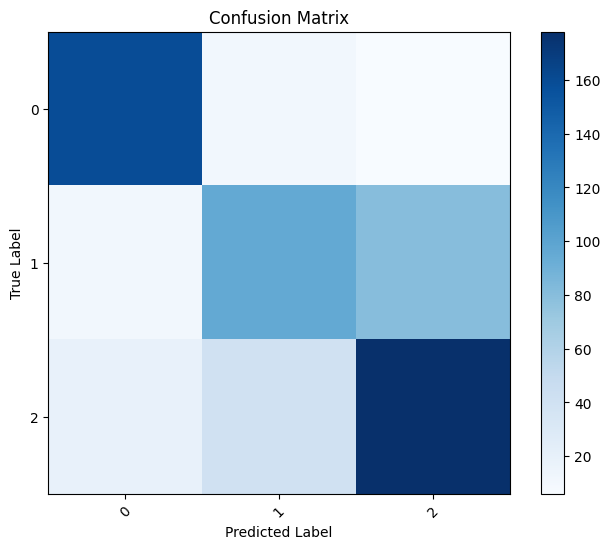

In [44]:
trainer.fit()

## Loss Plot

Text(0.5, 1.0, 'Loss')

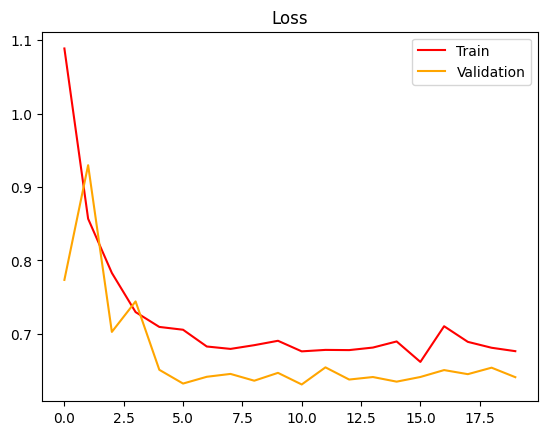

In [45]:
plt.plot(get_metric(trainer.train_logs,'train','loss'), color='red')
plt.plot(get_metric(trainer.val_logs,'val','loss'), color='orange')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.title('Loss')

## Accuracy Plot

Text(0.5, 1.0, 'Accuracy')

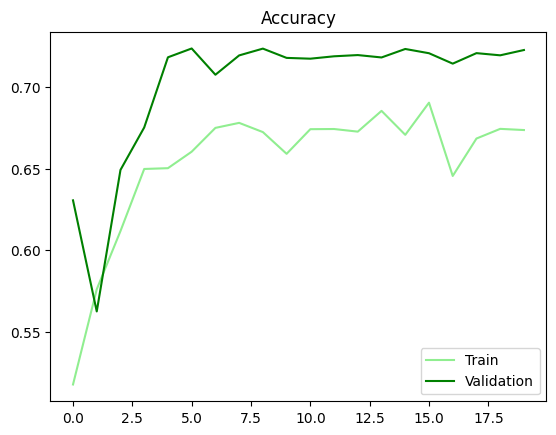

In [46]:
plt.plot(get_metric(trainer.train_logs,'train','Accuracy'), color='lightgreen')
plt.plot(get_metric(trainer.val_logs,'val','Accuracy'), color='green')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.title('Accuracy')

## Precision Plot

Text(0.5, 1.0, 'Precision')

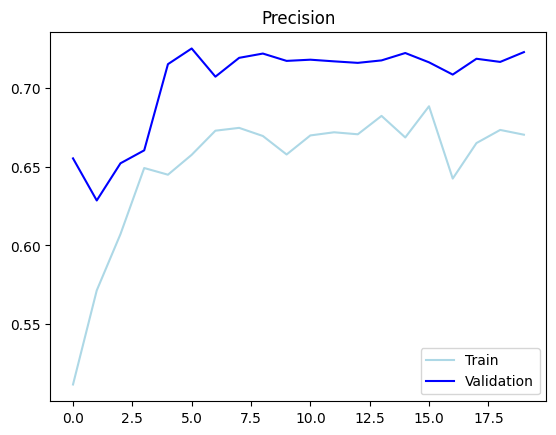

In [47]:
plt.plot(get_metric(trainer.train_logs,'train','Precision'), color='lightblue')
plt.plot(get_metric(trainer.val_logs,'val','Precision'), color='blue')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.title('Precision')

## Recall Plot

Text(0.5, 1.0, 'Recall')

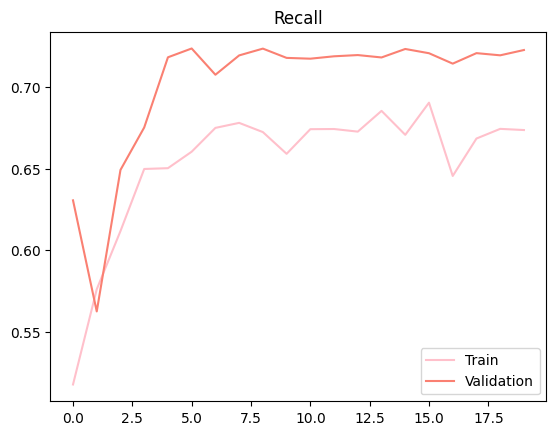

In [48]:
plt.plot(get_metric(trainer.train_logs,'train','Recall'), color='pink')
plt.plot(get_metric(trainer.val_logs,'val','Recall'), color='salmon')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.title('Recall')

## F1Score Plot

Text(0.5, 1.0, 'F1Score')

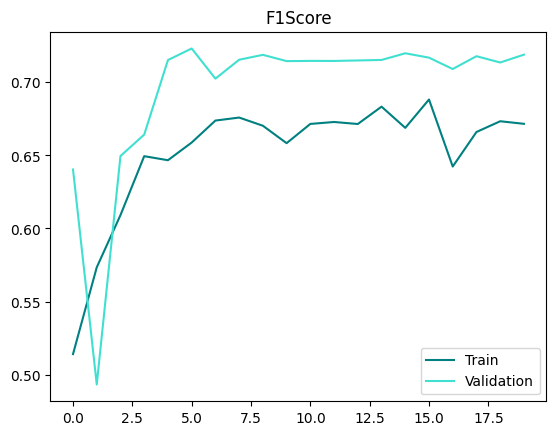

In [49]:
plt.plot(get_metric(trainer.train_logs,'train','F1Score'), color='teal')
plt.plot(get_metric(trainer.val_logs,'val','F1Score'), color='turquoise')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.title('F1Score')